# Исследование сервиса аренды самокатов GoFast

В нашем распоряжении данные о некоторых пользователях из нескольких городов, а также об их поездках через сервис аренды самокатов GoFast.
1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки?
2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
4. Повлияло ли обновление серверов, с которыми взаимодействует мобильное приложение, на количество обращений в техподдержку?

# Описание данных

**1. Пользователи (users_go.csv)**

*user_id* - уникальный идентификатор пользователя

*name* - имя пользователя

*age* - возраст

*city* - город

*subscription_type* - тип подписки (free, ultra)

**2. Поездки (rides_go.csv)**

*user_id* - уникальный идентификатор пользователя

*distance* - расстояние, которое пользователь проехал в текущей сессии (в метрах)

*duration* - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»

*date* - дата совершения поездки

**3. Подписки (subscriptions_go.csv)**

*subscription_type* - тип подписки

*minute_price* - стоимость одной минуты поездки по данной подписке

*start_ride_price* - стоимость начала поездки

*subscription_fee* - стоимость ежемесячного платежа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from matplotlib import transforms

#### Загрузка данных

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
try:
    rides = pd.read_csv('/datasets/rides_go.csv')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


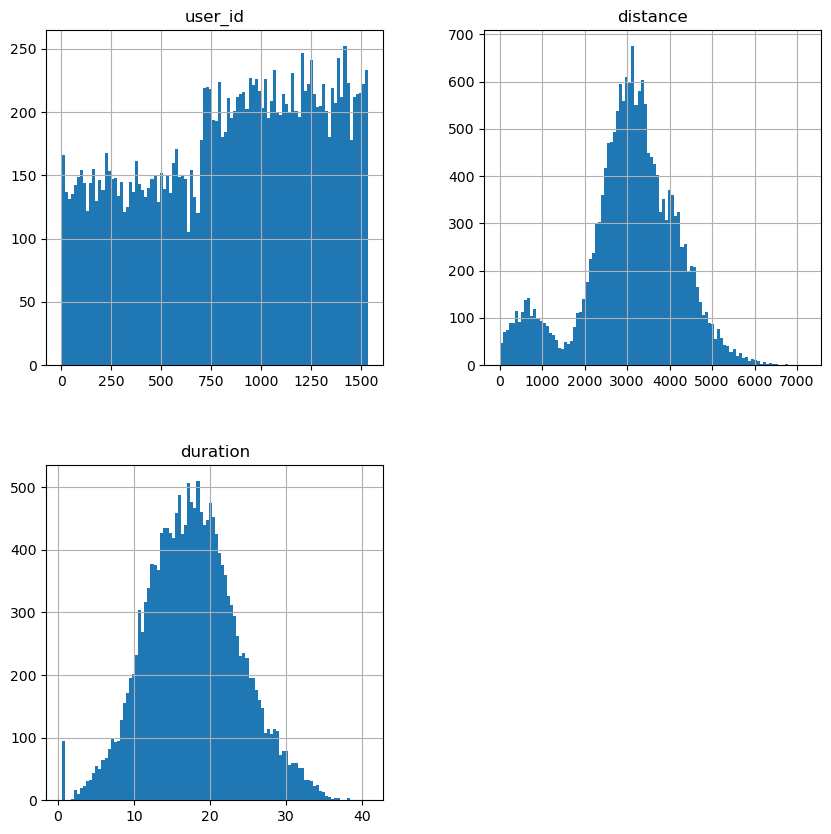

In [6]:
rides.hist(bins=100, figsize=(10, 10))
plt.show()

In [7]:
try:
    subs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Данные получены в надлежащем состоянии:
* Пропущенные значения отсутствуют
* Типы данных почти везде указаны верно
* Выбросов при первом знакомстве не наблюдается
* Данных достаточно для проведения анализа

#### Предобработка данных

Исправим тип данных в таблице rides в столбце с датой.

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
type(rides.loc[0,'date'])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [11]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

Все данные представлены за период с 1 января до 30 декабря 2021 года. Для удобства анализа создадим новый столбец с номером месяца для таблицы rides.

In [12]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверим данные на наличие дубликатов. Удалим дубликаты при их наличии.

In [13]:
users.duplicated().sum()

31

In [14]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

In [15]:
rides.duplicated().sum()

0

Данные подготовлены к работе:
* Исправлен тип данных в таблице rides в столбце с датой.
* Для удобства анализа создан новый столбец в таблице rides с номером месяца.
* Удалены 31 дублирующихся строки.

#### Исследовательский анализ данных

##### Частота встречаемости городов

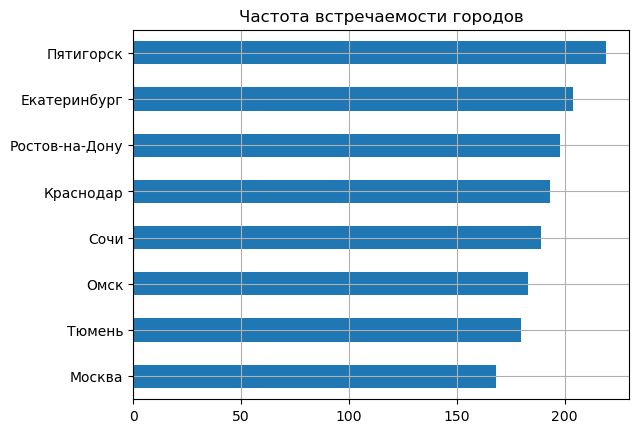

In [16]:
users['city'].value_counts().sort_values(ascending=True).plot(kind='barh', grid=True,)
plt.title('Частота встречаемости городов')
plt.show()

In [17]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [18]:
100 - 100 / users.query('city == "Пятигорск"').count()['city'] * users.query('city == "Москва"').count()['city']

23.28767123287672

Популярнее всего сервис в Пятигорске, меньше всего данных о пользователях из Москвы. При этом количество данных по городам распределено достаточно равномерно, разница в количестве данных между Пятигорском и Москвой всего 23%.

##### Соотношение пользователей с подпиской и без подписки

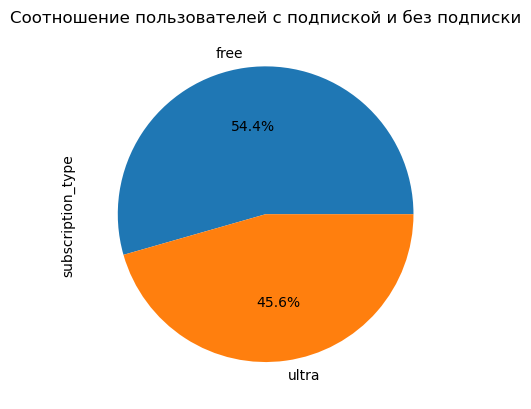

In [19]:
users['subscription_type'].value_counts().plot(kind='pie', grid=True, autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

Почти половина поездок прошла по подписке ultra.

##### Возраст пользователей

In [20]:
users['age'].max()-users['age'].min()

31

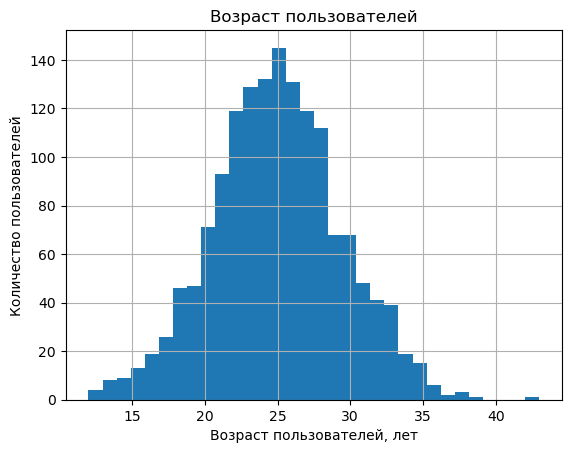

In [21]:
users['age'].hist(bins=32)
plt.title('Возраст пользователей')
plt.xlabel('Возраст пользователей, лет')
plt.ylabel('Количество пользователей')
plt.show()

Наибольшей популярностью сервис пользуется у людей в возрасте от 20 до 30 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

In [22]:
def my_round(x, r):
    m = np.ceil(x / r) * r
    return m
for t in range(len(rides)):
    rides.loc[t, 'distance_round'] = int(my_round(rides.loc[t, 'distance'], 500))

In [23]:
# код ревьюера
rides['distance_round'].astype(int)

0        4500
1        3000
2        1000
3        3000
4        4500
         ... 
18063    4000
18064    3000
18065    4000
18066    3000
18067    2500
Name: distance_round, Length: 18068, dtype: int32

In [24]:
len(rides['distance_round'].unique())

15

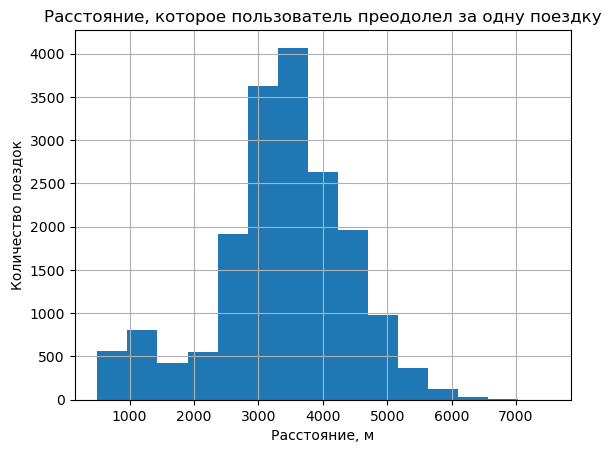

In [25]:
rides['distance_round'].hist(bins=15)
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

Чаще всего самокаты берут в аренду для поездок на расстояние от 2,5 до 4,5 км.

##### Продолжительность поездок

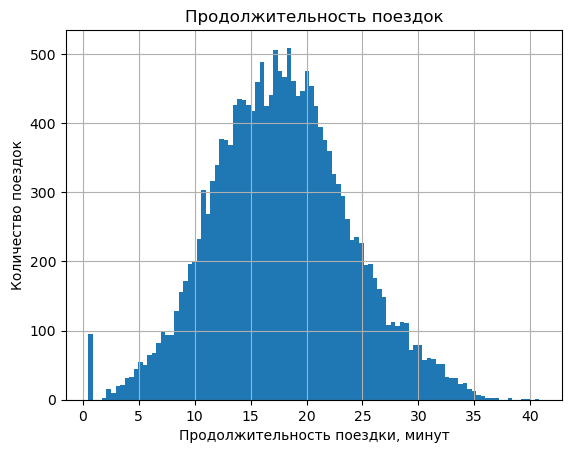

In [26]:
rides['duration'].hist(bins=100)
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность поездки, минут')
plt.ylabel('Количество поездок')
plt.show()

In [27]:
rides['duration'].median()

17.678394530393803

Среднее время поездки 17 минут 40 секунд. Чаще всего поездки длятся от 13 до 21 минуты.

#### Объединение данных

##### Объединим данные в одну таблицу.

In [28]:
general_df = rides.merge(users, on='user_id', how='left')

In [29]:
general_df = general_df.merge(subs, on='subscription_type', how='left')

In [30]:
general_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   distance_round     18068 non-null  float64       
 6   name               18068 non-null  object        
 7   age                18068 non-null  int64         
 8   city               18068 non-null  object        
 9   subscription_type  18068 non-null  object        
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memory 

In [31]:
rides['user_id'].count()

18068

##### Поделим таблицу на две: 
* c данными о пользователях без подписки;
* с данными о пользователях с подпиской.

In [32]:
general_df_free = general_df.query('subscription_type == "free"')
general_df_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   distance_round     11568 non-null  float64       
 6   name               11568 non-null  object        
 7   age                11568 non-null  int64         
 8   city               11568 non-null  object        
 9   subscription_type  11568 non-null  object        
 10  minute_price       11568 non-null  int64         
 11  start_ride_price   11568 non-null  int64         
 12  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memo

In [33]:
general_df_ultra = general_df.query('subscription_type == "ultra"')
general_df_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   distance_round     6500 non-null   float64       
 6   name               6500 non-null   object        
 7   age                6500 non-null   int64         
 8   city               6500 non-null   object        
 9   subscription_type  6500 non-null   object        
 10  minute_price       6500 non-null   int64         
 11  start_ride_price   6500 non-null   int64         
 12  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memory us

##### Расстояние поездки

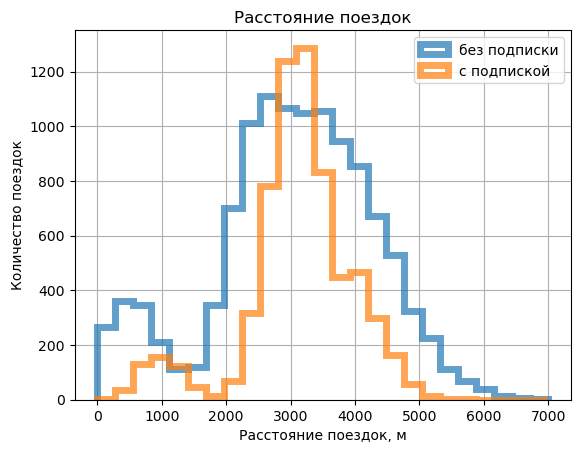

In [34]:
ax = general_df_free.plot(kind='hist', y='distance', histtype='step', range=(0, 7000), bins=25, linewidth=5, 
                          alpha=0.7, label='без подписки')
general_df_ultra.plot(kind='hist', y='distance', histtype='step', range=(0, 7000), bins=25, linewidth=5, alpha=0.7, 
                      label='с подпиской', ax=ax, grid=True, legend=True)
plt.title('Расстояние поездок')
plt.xlabel('Расстояние поездок, м')
plt.ylabel('Количество поездок')
plt.show()

1. Для пользователей без подписки наблюдается большое количество поездок на расстояние около 0 метров. Предположительно это связано с тем, что часть новых пользователей не смогли начать поездку, другая часть пользователей просто опробовала сервис.
2. На обоих графиках прослеживается явное разделение на короткие и более продолжительные поездки. Для пользователей без подписки эта граница находится на расстоянии примерно от 1100 до 1700 метров, для пользователей с подпиской - от 1600 до 1900 метров.
3. Обе категории пользователей чаще всего проезжают растояние около 3000 метров. Для пользователей без подписки этот пик более размыт: от 2200 до 3600 метров. Для пользователей с подпиской пик выражен четче: от 2800 до 3400 метров.

В остальном распределения похожи, необходимо учитывать то, что поездок без подписки почти в 2 раза больше, чем поездок с подпиской.

##### Продолжительность поездки

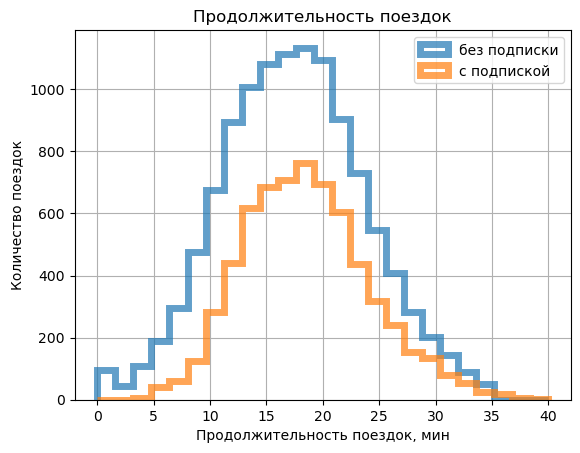

In [35]:
ax = general_df_free.plot(kind='hist', y='duration', histtype='step', range=(0, 40), bins=25, linewidth=5, 
                          alpha=0.7, label='без подписки')
general_df_ultra.plot(kind='hist', y='duration', histtype='step', range=(0, 40), bins=25, linewidth=5, alpha=0.7, 
                      label='с подпиской', ax=ax, grid=True, legend=True)
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность поездок, мин')
plt.ylabel('Количество поездок')
plt.show()

Учитывая то, что поездок без подписки почти в 2 раза больше, чем поездок с подпиской, различий в поведении групп пользователей не наблюдается.

#### Подсчёт выручки

##### Создание новой таблицы таблицы
Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Данные запишем в новую таблицу.

In [36]:
fee_df = general_df.copy()

In [37]:
fee_df['duration'] = np.ceil(fee_df['duration'])

In [38]:
fee_df = fee_df.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc=['sum', 'count'])
fee_df.columns = ['distance', 'duration', 'rides_count', 'count']

In [39]:
fee_df = fee_df.reset_index()

In [40]:
fee_df = fee_df.drop('count', axis=1)

In [41]:
fee_df.head(10)

,user_id,month,distance,duration,rides_count
0,1,1,7027.511294,42.0,2
1,1,4,754.159807,7.0,1
2,1,8,6723.470560,46.0,2
3,1,10,5809.911100,32.0,2
4,1,11,7003.499363,56.0,3
5,1,12,6751.629942,28.0,2
6,2,3,10187.723006,63.0,3
7,2,4,6164.381824,40.0,2
8,2,6,3255.338202,14.0,1
9,2,7,6780.722964,48.0,2


##### Дополнение таблицы
Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [42]:
fee_df = fee_df.merge(users[['user_id', 'subscription_type']], on='user_id', how='left')

In [43]:
fee_df.head(10)

,user_id,month,distance,duration,rides_count,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,46.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,56.0,3,ultra
5,1,12,6751.629942,28.0,2,ultra
6,2,3,10187.723006,63.0,3,ultra
7,2,4,6164.381824,40.0,2,ultra
8,2,6,3255.338202,14.0,1,ultra
9,2,7,6780.722964,48.0,2,ultra


In [44]:
fee_df = fee_df.merge(subs, on='subscription_type', how='left')

In [45]:
fee_df.head(10)

,user_id,month,distance,duration,rides_count,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,42.0,2,ultra,6,0,199
1,1,4,754.159807,7.0,1,ultra,6,0,199
2,1,8,6723.470560,46.0,2,ultra,6,0,199
3,1,10,5809.911100,32.0,2,ultra,6,0,199
4,1,11,7003.499363,56.0,3,ultra,6,0,199
5,1,12,6751.629942,28.0,2,ultra,6,0,199
6,2,3,10187.723006,63.0,3,ultra,6,0,199
7,2,4,6164.381824,40.0,2,ultra,6,0,199
8,2,6,3255.338202,14.0,1,ultra,6,0,199
9,2,7,6780.722964,48.0,2,ultra,6,0,199


In [46]:
fee_df['gain'] = fee_df['start_ride_price'] * fee_df['rides_count'] + fee_df['minute_price'] * fee_df['duration'] + \
fee_df['subscription_fee']

In [47]:
fee_df.drop(['minute_price', 'start_ride_price', 'subscription_fee'], axis= 1 , inplace= True)

In [48]:
fee_df.head(10)

,user_id,month,distance,duration,rides_count,subscription_type,gain
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,4,754.159807,7.0,1,ultra,241.0
2,1,8,6723.470560,46.0,2,ultra,475.0
3,1,10,5809.911100,32.0,2,ultra,391.0
4,1,11,7003.499363,56.0,3,ultra,535.0
5,1,12,6751.629942,28.0,2,ultra,367.0
6,2,3,10187.723006,63.0,3,ultra,577.0
7,2,4,6164.381824,40.0,2,ultra,439.0
8,2,6,3255.338202,14.0,1,ultra,283.0
9,2,7,6780.722964,48.0,2,ultra,487.0


#### Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки? 

**Нулевая гипотеза:**

Пользователи с подпиской и пользователи без подписки в среднем тратят одинаковое время на поездку.

**Альтернативная гипотеза:**

Пользователи с попиской тратят на поездку больше времени, чем пользователи без подписки.

In [49]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(
    general_df_ultra['duration'], 
    general_df_free['duration'], 
    alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [50]:
print('Средняя продолжительность поездки пользователей без подписки:', round(general_df_free['duration'].mean(), 1), 'минут')
print('Средняя продолжительность поездки пользователей с подпиской:', round(general_df_ultra['duration'].mean(), 1), 'минут')
print('Средняя продолжительность поездки пользователей с подпиской больше на', round(100 / general_df_free['duration'].mean() * \
      general_df_ultra['duration'].mean() - 100, 1), '%')

Средняя продолжительность поездки пользователей без подписки: 17.4 минут
Средняя продолжительность поездки пользователей с подпиской: 18.5 минут
Средняя продолжительность поездки пользователей с подпиской больше на 6.6 %


**Вывод:**

Пользователи с попиской тратят на поездку больше времени, чем пользователи без подписки примерно на **6.6%**

##### Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

**Нулевая гипотеза:**

Пользователи с подпиской в среднем проезжают за одну поездку 3130 метров.

**Альтернативная гипотеза:**

Пользователи с подпиской проезжают за одну поездку более 3130 метров.

In [51]:
alpha = 0.05 # уровень статистической значимости

interested_value = 3130

results = st.ttest_1samp(
    general_df_ultra['distance'], 
    interested_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


**Вывод:**

Cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Нулевая гипотеза:**

Помесячная выручка по месяцам от пользователей с подпиской равна помесячной выручке по месяцам от пользователей без подписки.

**Альтернативная гипотеза:**

Помесячная выручка от пользователей с подпиской по месяцам выше, чем помесячная выручка от пользователей без подписки.

In [52]:
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(
    fee_df.query('subscription_type == "ultra"')['gain'], 
    fee_df.query('subscription_type == "free"')['gain'], 
    alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [53]:
gain_ultra = fee_df.query('subscription_type == "ultra"')['gain'].median()

In [54]:
gain_free = fee_df.query('subscription_type == "free"')['gain'].median()

In [55]:
print('Помесячная выручка от пользователей без подписки:', gain_free, 'рублей')
print('Помесячная выручка от пользователей с подпиской:', gain_ultra, 'рублей')
print('Помесячная выручка от пользователей с подпиской больше на', round(100 / gain_free * gain_ultra - 100, 1), '%')

Помесячная выручка от пользователей без подписки: 274.0 рублей
Помесячная выручка от пользователей с подпиской: 337.0 рублей
Помесячная выручка от пользователей с подпиской больше на 23.0 %


**Вывод:**

Помесячная выручка от пользователей с подпиской по месяцам выше на 23 %, чем помесячная выручка от пользователей без подписки.

#### Общий вывод

**В ходе исследования были сделаны следующие выводы:**

1. *Популярнее всего сервис в **Пятигорске**.* При этом количество данных по городам распределено достаточно равномерно, разница в количестве данных между Пятигорском и Москвой (откуда данных меньше всего) составляет 23%.

2. Соотношение пользователей:
* Пользователей **без подписки: 54.4%**
* Пользователей **с подпиской: 45.6%**

3. Наибольшей популярностью сервис пользуется у людей в возрасте от **20 до 30 лет**.

4. Чаще всего самокаты берут в аренду для поездок **на расстояние от 2,5 до 4,5 км**.

5. Среднее время поездки **17 минут 40 секунд**. Чаще всего поездки длятся от **13 до 21 минуты**.

**Проверка гипотез:**
    
1. *Тратят ли пользователи с подпиской больше времени на поездки?*

*Ответ:* **Да**, пользователи с попиской тратят на поездку больше времени, чем пользователи без подписки примерно **на 6.6%**.

2. *Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?*

*Ответ:* **Да**, cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

3. *Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?*

*Ответ:* **Да**, помесячная выручка от пользователей с подпиской по месяцам **выше на 23 %**, чем помесячная выручка от пользователей без подписки.

4. *Повлияло ли обновление серверов, с которыми взаимодействует мобильное приложение, на количество обращений в техподдержку?*

*Ответ:* Для проверки этой гипотезы понадобится файл, содержащий для каждого пользователя данные о количестве обращений до обновления и после него. Так как выборки являются зависимыми, сравнивать будем с помощью метода scipy.stats.ttest_rel(), которму передадим два параметра: наборы данных до и после.